Assumptions:
- No data leakage issues
- use arrival delay as ultimate measure of delay
- can use CRS departure and arrival time for prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor,XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score,log_loss, precision_score, recall_score, fbeta_score
from sklearn.metrics import confusion_matrix, f1_score
import catboost as cb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.under_sampling import NearMiss


pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-dark-palette')

C:\Users\LAIW0\AppData\Local\Temp\ipykernel_8044\688505655.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [2]:
parquet_files = glob.glob('./input/Combined_Flights_*.parquet')

In [4]:
#only subset can only be used as too much ram is required
column_subset = [
    # "FlightDate",
    "Airline",
    "Tail_Number",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    # "OriginAirportID", removed after checking feature importance
    # "OriginCityName",
    # "OriginStateName",
    # "DestAirportID", removed after checking feature importance
    # "DestCityName",
    # "DestStateName",
    "TaxiOut",
    "TaxiIn",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
    "Year",
    "Month",
]

In [5]:
def frequency_encode(column, data):
  """
  Encodes a categorical column based on its frequency in the data.

  Args:
      column (str): Name of the categorical column.
      data (pd.DataFrame): DataFrame containing the data.

  Returns:
      pd.DataFrame: Dataframe with the encoded feature added.
  """
  counts = data[column].value_counts()
  total_count = len(data)
  encoded_data = data.copy()
  encoded_data[column + '_freq'] = data[column].apply(lambda x: counts[x] / total_count)
  return encoded_data

In [8]:
def process_file(df_flights):
  """
  Processes each parquet file as file is too huge to process together.

  Args:
      
      df (pd.DataFrame): DataFrame containing the data.

  Returns:
      pd.DataFrame: Dataframe that has been pre-processed.
  """
  # Replace NaN values in 'Tail_Number' with 'None'
  df_flights['Tail_Number']= df_flights['Tail_Number'].fillna('None')

  cat_col = ['Airline','Origin','Dest','Tail_Number',
            #  'OriginStateName','DestStateName','OriginCityName',
            #  'DestCityName'
             ]
  #convert to category to reduce ram usage
  for c in cat_col:
    df_flights[c] = df_flights[c].astype("category") 
  
  # Drop duplicate rows
  df_flights.drop_duplicates()

  #select all rows that are na 
  df_flights_na = df_flights[df_flights[['ArrTime', 'DepTime']].isnull().any(axis=1)]
  #retain only rows where flights are cancelled (as it would be normal for cancelled flights to not have arrival/departure time)
  df_flights_na = df_flights_na[df_flights_na['Cancelled'] == True]

  # drop rows that have doesnt have values for arrival/departure time
  df_flights.dropna(subset=['ArrTime', 'DepTime'], inplace=True)

  # pad departure time with leading zeroes
  df_flights['DepTime'] = df_flights['DepTime'].astype(int).astype(str).str.zfill(4)
  df_flights['CRSDepTime'] = df_flights['CRSDepTime'].astype(int).astype(str).str.zfill(4)

  #recompute delay using difference between CRSDepTime and DepTime
  df_flights = df_flights[df_flights['DepTime']!='2400']
  df_flights['DepTimeDateTime'] = pd.to_datetime(df_flights['DepTime'], format="%H%M")
  df_flights = df_flights[df_flights['CRSDepTime']!='2400'] 
  df_flights['CRSDepTimeDateTime']= pd.to_datetime(df_flights['CRSDepTime'], format="%H%M")

  df_flights['DepDelay'] = (df_flights['DepTimeDateTime'] - df_flights['CRSDepTimeDateTime']).astype('timedelta64[s]')/60
  df_flights['DepDelayMinutes'] = df_flights['DepDelay'].apply(lambda x: x if x > 0 else 0)
  df_flights.drop(columns =['DepTimeDateTime','CRSDepTimeDateTime'])

  # pad arrival time with leading zeroes
  df_flights['ArrTime'] = df_flights['ArrTime'].astype(int).astype(str).str.zfill(4)
  df_flights['CRSArrTime'] = df_flights['CRSArrTime'].astype(int).astype(str).str.zfill(4)
  
  #recompute delay using difference between CRSArrTime and ArrTime
  df_flights = df_flights[df_flights['ArrTime']!='2400']
  df_flights['ArrTimeDateTime'] = pd.to_datetime(df_flights['ArrTime'], format="%H%M")
  df_flights = df_flights[df_flights['CRSArrTime']!='2400']
  df_flights['CRSArrTimeDateTime']= pd.to_datetime(df_flights['CRSArrTime'], format="%H%M")

  df_flights['ArrDelay'] = (df_flights['ArrTimeDateTime'] - df_flights['CRSArrTimeDateTime']).astype('timedelta64[s]')/60
  df_flights['ArrDelayMinutes'] = df_flights['ArrDelay'].apply(lambda x: x if x > 0 else 0)
  df_flights.drop(columns =['ArrTimeDateTime','CRSArrTimeDateTime'])

  #add back cancelled flights to dataframe
  df_flights = pd.concat([df_flights, df_flights_na], ignore_index=True)

  #categorise flights into cancelled,delayed and on time/early
  df_flights['DelayGroup'] = None
  df_flights.loc[df_flights['ArrDelayMinutes'] == 0, 'DelayGroup'] = 'On_Time_Early'
  # df_flights.loc[(df_flights['DepDelayMinutes'] > 0) & (df_flights['DepDelayMinutes'] <= 15), 'DelayGroup'] = 'Small_Delay'
  # df_flights.loc[(df_flights['DepDelayMinutes'] > 15) & (df_flights['DepDelayMinutes'] <= 45), 'DelayGroup'] = 'Medium_Delay'
  # df_flights.loc[df_flights['DepDelayMinutes'] > 45, 'DelayGroup'] = 'Large_Delay'
  df_flights.loc[df_flights['ArrDelayMinutes'] > 0, 'DelayGroup'] = 'Delayed'
  df_flights.loc[df_flights['Cancelled'], 'DelayGroup'] = 'Cancelled'

  y = df_flights["DelayGroup"]
  features =  [
      # "FlightDate",
      "Airline",
      "Tail_Number",
      "Flight_Number_Marketing_Airline",
      "Origin",
      "Dest",
      "CRSDepTime",
      "CRSArrTime",
    #   "OriginAirportID",
      # "OriginCityName",
      # "OriginStateName",
    #   "DestAirportID",
      # "DestCityName",
      # "DestStateName",
      "Year",
      "Month",
  ]
  X = df_flights[features]


  # Handle categorical features with frequency encoding so that they can be undersampled using Near Miss:

  le = LabelEncoder()
  for col in cat_col:
      X.loc[:, col] = le.fit_transform(X[col])  # Use .loc for explicit assignment



  # Apply frequency encoding:
  for col in cat_col:
      X = frequency_encode(col, X)
      X.drop(col, axis=1, inplace=True)  # Remove original categorical column

  return X,y

In [9]:
dfs_X = []
dfs_y = []
for f in parquet_files:
    df = pd.read_parquet(f, columns=column_subset)
    X_temp , y_temp = process_file(df)
    dfs_X.append(X_temp)
    dfs_y.append(y_temp)
X = pd.concat(dfs_X).reset_index(drop=True)
y= pd.concat(dfs_y).reset_index(drop=True)
# df_flights = pd.read_parquet(parquet_files[3], columns=column_subset)

C:\Users\LAIW0\AppData\Local\Temp\ipykernel_8044\1699783291.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flights['DepTimeDateTime'] = pd.to_datetime(df_flights['DepTime'], format="%H%M")
C:\Users\LAIW0\AppData\Local\Temp\ipykernel_8044\1699783291.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, col] = le.fit_transform(X[col])  # Use .loc for explicit assignment
C:\Users\LAIW0\AppData\Local\Temp\ipykernel_8044\1699783291.py:100: DeprecationWarning: In a future version, `df.iloc[:, i]

In [10]:
# undersample to a specific proportion of the minority class size:
minority_class_size = min(Counter(y).values())
undersampling_ratio = 5 # Set this to the desired ratio (e.g., 2x of minority class)
n_samples = minority_class_size * undersampling_ratio
# Use NearMiss for efficient nearest neighbor-based undersampling
nearmiss = NearMiss(sampling_strategy={'On_Time_Early': n_samples,'Delayed': n_samples})
X_resampled, y_resampled = nearmiss.fit_resample(X, y)
train_X, X_test, train_y, y_test = train_test_split(X_resampled, y_resampled, random_state=2024)


# Compute class weights for balanced training
classes = np.unique(y_resampled)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)
class_weights = dict(zip(classes, weights))

# Train CatBoost model with undersampled data and class weights
model = cb.CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights=class_weights,
                                iterations=500, learning_rate=0.01,
                                thread_count=None, random_state=2024)

model.fit(train_X, train_y,
             eval_set=(X_test, y_test),
             early_stopping_rounds=5,
            #  cat_features=cat_col,
             use_best_model=True)
y_pred_test = model.predict(X_test)
score = accuracy_score(y_test, y_pred_test)
print(score)

y_pred_proba = model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)
print(f"Multiclass Log Loss: {logloss:.4f}")

0:	learn: 0.6906826	test: 0.6906749	best: 0.6906749 (0)	total: 1.5s	remaining: 12m 27s
1:	learn: 0.6882020	test: 0.6881860	best: 0.6881860 (1)	total: 2.96s	remaining: 12m 17s
2:	learn: 0.6857745	test: 0.6857505	best: 0.6857505 (2)	total: 4.31s	remaining: 11m 54s
3:	learn: 0.6833940	test: 0.6833617	best: 0.6833617 (3)	total: 5.61s	remaining: 11m 35s
4:	learn: 0.6811088	test: 0.6810690	best: 0.6810690 (4)	total: 6.89s	remaining: 11m 22s
5:	learn: 0.6788643	test: 0.6788176	best: 0.6788176 (5)	total: 8.15s	remaining: 11m 10s
6:	learn: 0.6766021	test: 0.6765480	best: 0.6765480 (6)	total: 9.4s	remaining: 11m 2s
7:	learn: 0.6744435	test: 0.6743825	best: 0.6743825 (7)	total: 10.6s	remaining: 10m 53s
8:	learn: 0.6722706	test: 0.6722020	best: 0.6722020 (8)	total: 11.9s	remaining: 10m 48s
9:	learn: 0.6701879	test: 0.6701127	best: 0.6701127 (9)	total: 13.1s	remaining: 10m 42s
10:	learn: 0.6680858	test: 0.6680037	best: 0.6680037 (10)	total: 14.4s	remaining: 10m 40s
11:	learn: 0.6660770	test: 0.6659

C:\Users\LAIW0\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Confusion Matrix with Labels:
                Cancelled  Delayed  On_Time_Early
Cancelled          93538    55674          44842
Delayed            32258   632950         306793
On_Time_Early      72264   425551         473615
f-2 score is : 0.5385
precision: 0.5381
recall: 0.5402


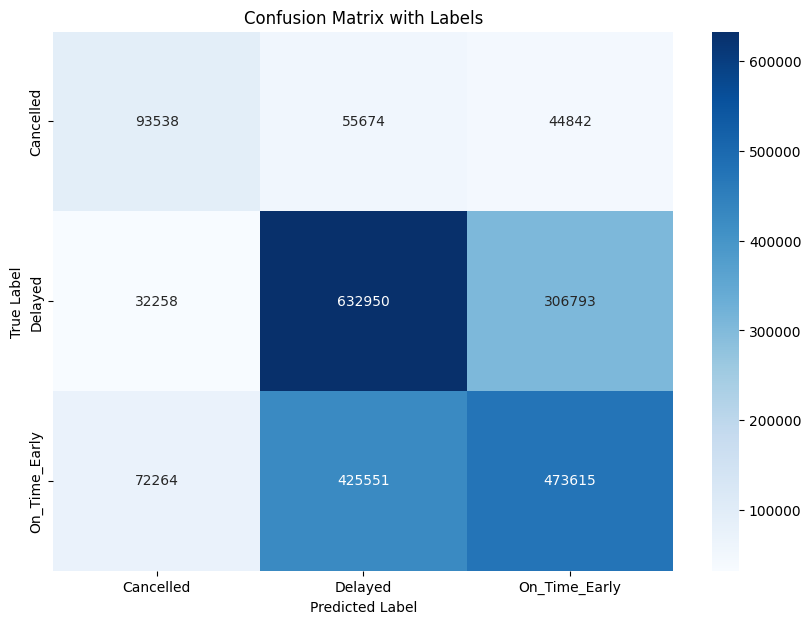

In [11]:
# Get predicted labels
y_pred = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract class labels from the target variable
class_labels = np.unique(y_test)

# Label the confusion matrix
cm_labeled = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Print the labeled confusion matrix
print("Confusion Matrix with Labels:\n", cm_labeled)

# Calculate precision, recall, and F2-score (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

beta = 2
#get F2 score (beta=2) , recall and precision equally weighted
fscore = fbeta_score(y_test,y_pred,beta = beta, average = 'macro')

print(f'f-{beta} score is : {fscore:.4f}')
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")


# Visualize the confusion matrix (optional)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm_labeled, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with Labels")
plt.show()

Text(0.5, 1.0, 'Feature Importance')

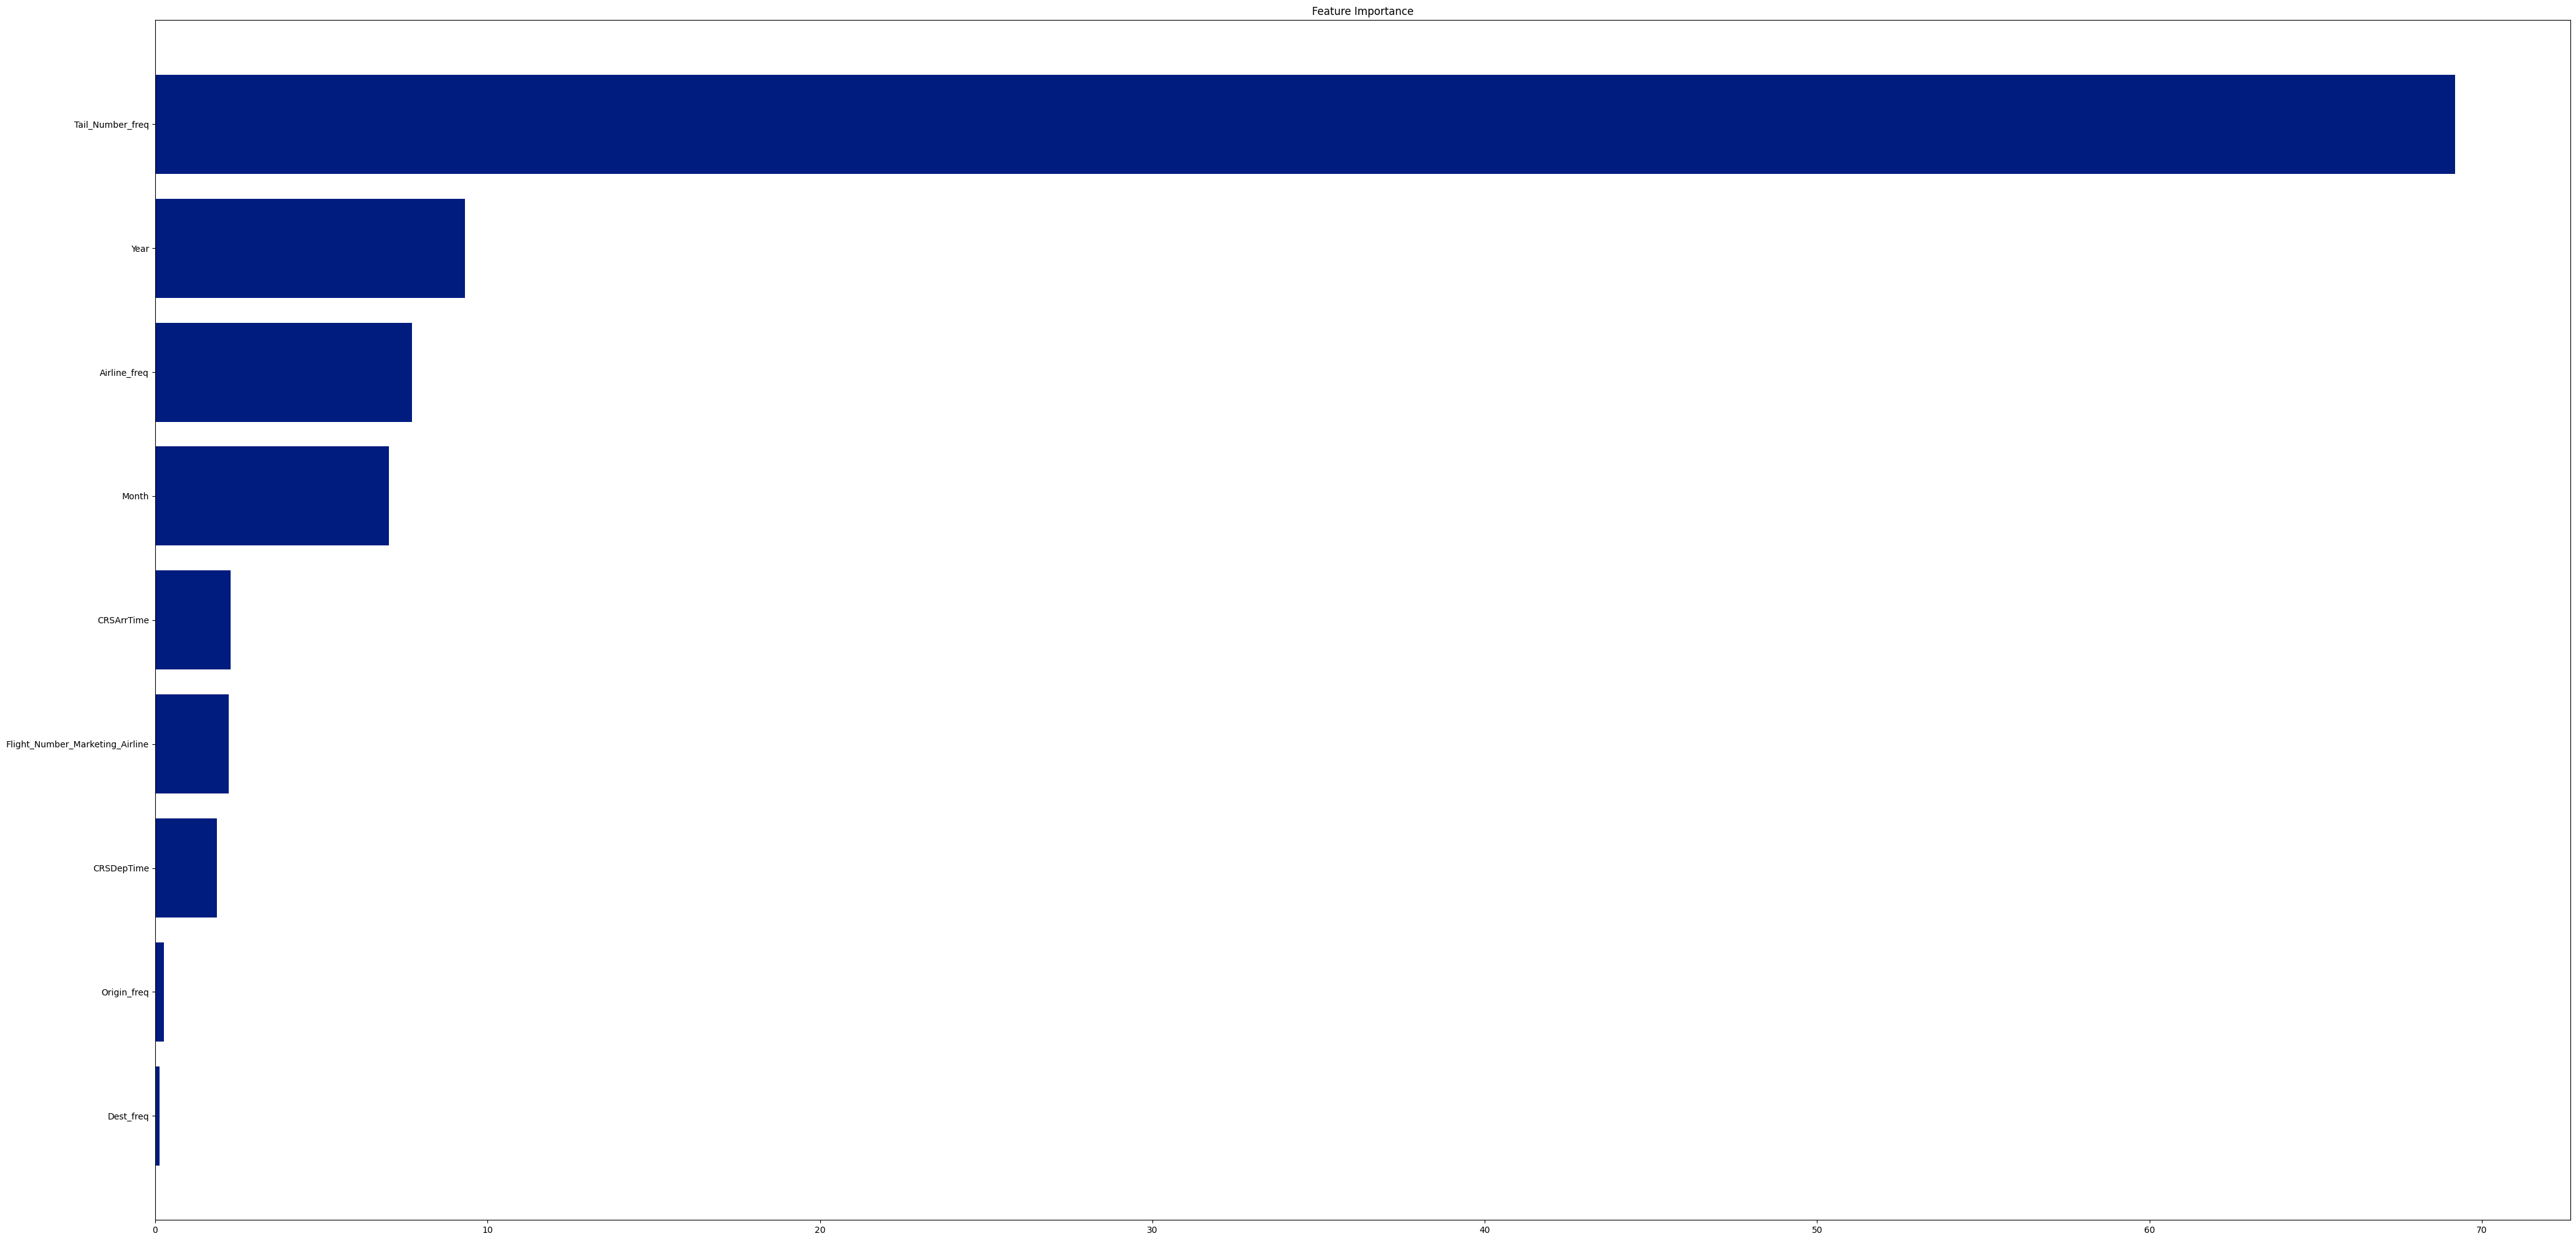

In [12]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(50, 25))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Text(0.5, 1.0, 'Permutation Importance')

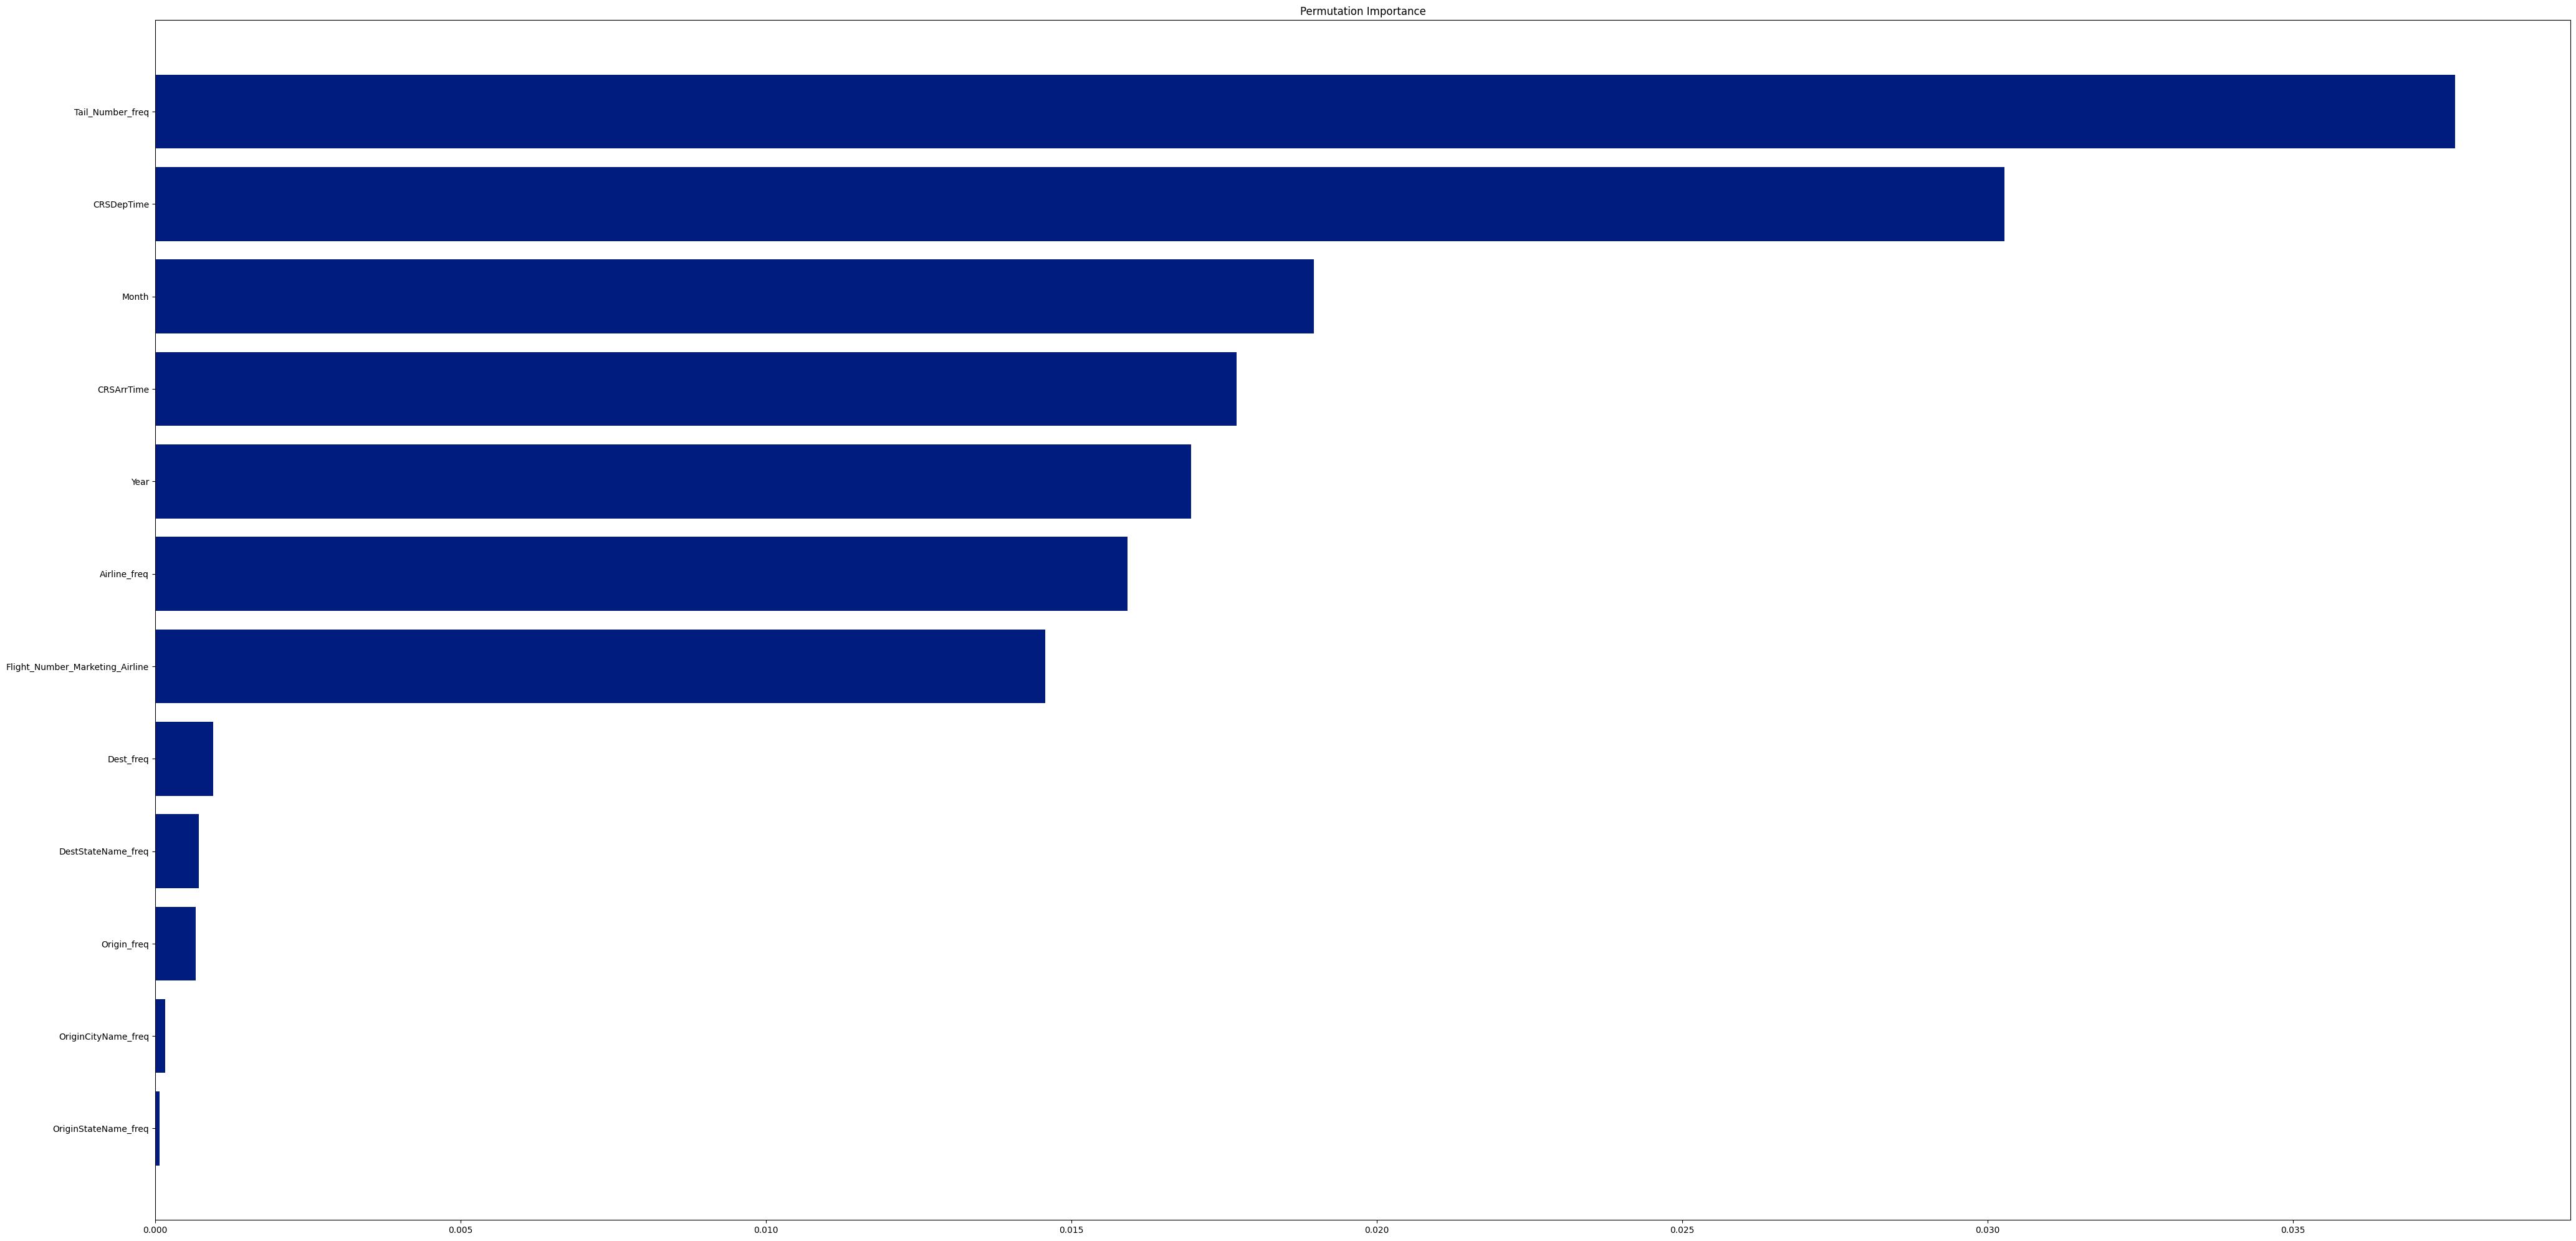

In [11]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(50, 25))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

Below this line are appendix and part of EDA
==============================================================================================================================================================================================================================================================

In [8]:
df_flights.tail()

,FlightDate,Airline,Tail_Number,Flight_Number_Marketing_Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,OriginAirportID,OriginCityName,OriginStateName,DestAirportID,DestCityName,DestStateName,TaxiOut,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes
573774,2021-06-01,Southwest Airlines Co.,N8695D,1740,BNA,MDW,False,False,1255,1301.0,6.0,10693,"Nashville, TN",Tennessee,13232,"Chicago, IL",Illinois,9.0,5.0,1430,1421.0,0.0
573775,2021-06-01,Southwest Airlines Co.,N7863A,2197,BNA,MDW,False,False,730,727.0,0.0,10693,"Nashville, TN",Tennessee,13232,"Chicago, IL",Illinois,13.0,3.0,900,845.0,0.0
573776,2021-06-01,Southwest Airlines Co.,N7867A,443,BNA,MIA,False,False,800,757.0,0.0,10693,"Nashville, TN",Tennessee,13303,"Miami, FL",Florida,14.0,5.0,1110,1101.0,0.0
573777,2021-06-01,Southwest Airlines Co.,N7827A,2991,BNA,MIA,False,False,1300,1252.0,0.0,10693,"Nashville, TN",Tennessee,13303,"Miami, FL",Florida,8.0,5.0,1620,1559.0,0.0
573778,2021-06-01,Southwest Airlines Co.,N919WN,886,BNA,MKE,False,False,1925,1948.0,23.0,10693,"Nashville, TN",Tennessee,13342,"Milwaukee, WI",Wisconsin,12.0,5.0,2055,2116.0,21.0


In [9]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6311871 entries, 0 to 573778
Data columns (total 22 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   FlightDate                       datetime64[ns]
 1   Airline                          category      
 2   Tail_Number                      category      
 3   Flight_Number_Marketing_Airline  int64         
 4   Origin                           category      
 5   Dest                             category      
 6   Cancelled                        bool          
 7   Diverted                         bool          
 8   CRSDepTime                       int64         
 9   DepTime                          float64       
 10  DepDelayMinutes                  float64       
 11  OriginAirportID                  int64         
 12  OriginCityName                   category      
 13  OriginStateName                  category      
 14  DestAirportID                    in

In [10]:
#remove rows where DepTime is NaN and flight is not cancelled
# mask = (df_flights['Cancelled'] == False) & df_flights['DepTime'].notna()
# df_mask = df_flights[mask]
# df_true = df_flights[df_flights['Cancelled'] == True]


# df_flights = pd.concat([df_true, df_mask], ignore_index=True)


In [11]:
# Drop duplicate rows
df_flights.drop_duplicates()

#select all rows that are na 
df_flights_na = df_flights[df_flights[['ArrTime', 'DepTime']].isnull().any(axis=1)]
#retain only rows where flights are cancelled (as it would be normal for cancelled flights to not have arrival/departure time)
df_flights_na = df_flights_na[df_flights_na['Cancelled'] == True]

# drop rows that have doesnt have values for arrival/departure time
df_flights.dropna(subset=['ArrTime', 'DepTime'], inplace=True)

# pad time with leading zeroes
df_flights['DepTime'] = df_flights['DepTime'].astype(int).astype(str).str.zfill(4)
df_flights['CRSDepTime'] = df_flights['CRSDepTime'].astype(int).astype(str).str.zfill(4)







In [12]:
df_flights_na.head(50)

,FlightDate,Airline,Tail_Number,Flight_Number_Marketing_Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,OriginAirportID,OriginCityName,OriginStateName,DestAirportID,DestCityName,DestStateName,TaxiOut,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes
93,2021-03-18,SkyWest Airlines Inc.,N753SK,2970,MKE,DFW,True,False,610,NaN,NaN,13342,"Milwaukee, WI",Wisconsin,11298,"Dallas/Fort Worth, TX",Texas,NaN,NaN,908,NaN,NaN
94,2021-03-18,SkyWest Airlines Inc.,N726SK,2972,DTW,ORD,True,False,1205,NaN,NaN,11433,"Detroit, MI",Michigan,13930,"Chicago, IL",Illinois,NaN,NaN,1234,NaN,NaN
95,2021-03-18,SkyWest Airlines Inc.,N606SK,2983,MDT,ORD,True,False,1119,NaN,NaN,13230,"Harrisburg, PA",Pennsylvania,13930,"Chicago, IL",Illinois,NaN,NaN,1229,NaN,NaN
98,2021-03-18,SkyWest Airlines Inc.,N604SK,3027,TVC,ORD,True,False,1204,NaN,NaN,15380,"Traverse City, MI",Michigan,13930,"Chicago, IL",Illinois,NaN,NaN,1224,NaN,NaN
99,2021-03-18,SkyWest Airlines Inc.,N604SK,3033,ORD,MSP,True,False,1335,NaN,NaN,13930,"Chicago, IL",Illinois,13487,"Minneapolis, MN",Minnesota,NaN,NaN,1507,NaN,NaN
100,2021-03-18,SkyWest Airlines Inc.,N603SK,3034,ORD,PIT,True,False,845,NaN,NaN,13930,"Chicago, IL",Illinois,14122,"Pittsburgh, PA",Pennsylvania,NaN,NaN,1122,NaN,NaN
104,2021-03-18,SkyWest Airlines Inc.,N606SK,3050,ORD,GRB,True,False,1345,NaN,NaN,13930,"Chicago, IL",Illinois,11977,"Green Bay, WI",Wisconsin,NaN,NaN,1451,NaN,NaN
105,2021-03-18,SkyWest Airlines Inc.,N709SK,3055,GRR,ORD,True,False,1210,NaN,NaN,11986,"Grand Rapids, MI",Michigan,13930,"Chicago, IL",Illinois,NaN,NaN,1217,NaN,NaN
106,2021-03-18,SkyWest Airlines Inc.,N709SK,3055,ORD,GRR,True,False,840,NaN,NaN,13930,"Chicago, IL",Illinois,11986,"Grand Rapids, MI",Michigan,NaN,NaN,1048,NaN,NaN
107,2021-03-18,SkyWest Airlines Inc.,N726SK,3070,ORD,IND,True,False,1334,NaN,NaN,13930,"Chicago, IL",Illinois,12339,"Indianapolis, IN",Indiana,NaN,NaN,1538,NaN,NaN


In [13]:
#recompute delay using difference between CRSDepTime and DepTime
df_flights = df_flights[df_flights['DepTime']!='2400']
df_flights['DepTimeDateTime'] = pd.to_datetime(df_flights['DepTime'], format="%H%M")
df_flights = df_flights[df_flights['CRSDepTime']!='2400'] 
df_flights['CRSDepTimeDateTime']= pd.to_datetime(df_flights['CRSDepTime'], format="%H%M")

df_flights['DepDelay'] = (df_flights['DepTimeDateTime'] - df_flights['CRSDepTimeDateTime']).astype('timedelta64[s]')/60
df_flights['DepDelayMinutes'] = df_flights['DepDelay'].apply(lambda x: x if x > 0 else 0)
df_flights.drop(columns =['DepTimeDateTime','CRSDepTimeDateTime'])


,FlightDate,Airline,Tail_Number,Flight_Number_Marketing_Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,OriginAirportID,OriginCityName,OriginStateName,DestAirportID,DestCityName,DestStateName,TaxiOut,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,DepDelay
0,2021-03-03,SkyWest Airlines Inc.,N728SK,3133,SGU,PHX,False,False,0724,0714,0.0,14794,"St. George, UT",Utah,14107,"Phoenix, AZ",Arizona,10.0,5.0,843,818.0,0.0,-10.0
1,2021-03-03,SkyWest Airlines Inc.,N752SK,3134,PHX,SGU,False,False,0922,0917,0.0,14107,"Phoenix, AZ",Arizona,14794,"St. George, UT",Utah,23.0,3.0,1040,1031.0,0.0,-5.0
2,2021-03-03,SkyWest Airlines Inc.,N766SK,3135,MHT,ORD,False,False,1330,1321,0.0,13296,"Manchester, NH",New Hampshire,13930,"Chicago, IL",Illinois,15.0,16.0,1530,1501.0,0.0,-9.0
3,2021-03-03,SkyWest Airlines Inc.,N752EV,3136,DFW,TRI,False,False,1645,1636,0.0,11298,"Dallas/Fort Worth, TX",Texas,15323,"Bristol/Johnson City/Kingsport, TN",Tennessee,27.0,7.0,2010,2002.0,0.0,-9.0
4,2021-03-03,SkyWest Airlines Inc.,N715SK,3137,PHX,BFL,False,False,1844,1838,0.0,14107,"Phoenix, AZ",Arizona,10561,"Bakersfield, CA",California,13.0,3.0,1925,1903.0,0.0,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573774,2021-06-01,Southwest Airlines Co.,N8695D,1740,BNA,MDW,False,False,1255,1301,6.0,10693,"Nashville, TN",Tennessee,13232,"Chicago, IL",Illinois,9.0,5.0,1430,1421.0,0.0,6.0
573775,2021-06-01,Southwest Airlines Co.,N7863A,2197,BNA,MDW,False,False,0730,0727,0.0,10693,"Nashville, TN",Tennessee,13232,"Chicago, IL",Illinois,13.0,3.0,900,845.0,0.0,-3.0
573776,2021-06-01,Southwest Airlines Co.,N7867A,443,BNA,MIA,False,False,0800,0757,0.0,10693,"Nashville, TN",Tennessee,13303,"Miami, FL",Florida,14.0,5.0,1110,1101.0,0.0,-3.0
573777,2021-06-01,Southwest Airlines Co.,N7827A,2991,BNA,MIA,False,False,1300,1252,0.0,10693,"Nashville, TN",Tennessee,13303,"Miami, FL",Florida,8.0,5.0,1620,1559.0,0.0,-8.0


In [14]:
# pad time with leading zeroes
df_flights['ArrTime'] = df_flights['ArrTime'].astype(int).astype(str).str.zfill(4)
df_flights['CRSArrTime'] = df_flights['CRSArrTime'].astype(int).astype(str).str.zfill(4)

In [15]:
#recompute delay using difference between CRSArrTime and ArrTime
df_flights = df_flights[df_flights['ArrTime']!='2400']
df_flights['ArrTimeDateTime'] = pd.to_datetime(df_flights['ArrTime'], format="%H%M")
df_flights = df_flights[df_flights['CRSArrTime']!='2400']
df_flights['CRSArrTimeDateTime']= pd.to_datetime(df_flights['CRSArrTime'], format="%H%M")

df_flights['ArrDelay'] = (df_flights['ArrTimeDateTime'] - df_flights['CRSArrTimeDateTime']).astype('timedelta64[s]')/60
df_flights['ArrDelayMinutes'] = df_flights['ArrDelay'].apply(lambda x: x if x > 0 else 0)
df_flights.drop(columns =['ArrTimeDateTime','CRSArrTimeDateTime'])

,FlightDate,Airline,Tail_Number,Flight_Number_Marketing_Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,OriginAirportID,OriginCityName,OriginStateName,DestAirportID,DestCityName,DestStateName,TaxiOut,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,DepTimeDateTime,CRSDepTimeDateTime,DepDelay,ArrDelay
0,2021-03-03,SkyWest Airlines Inc.,N728SK,3133,SGU,PHX,False,False,0724,0714,0.0,14794,"St. George, UT",Utah,14107,"Phoenix, AZ",Arizona,10.0,5.0,0843,0818,0.0,1900-01-01 07:14:00,1900-01-01 07:24:00,-10.0,-25.0
1,2021-03-03,SkyWest Airlines Inc.,N752SK,3134,PHX,SGU,False,False,0922,0917,0.0,14107,"Phoenix, AZ",Arizona,14794,"St. George, UT",Utah,23.0,3.0,1040,1031,0.0,1900-01-01 09:17:00,1900-01-01 09:22:00,-5.0,-9.0
2,2021-03-03,SkyWest Airlines Inc.,N766SK,3135,MHT,ORD,False,False,1330,1321,0.0,13296,"Manchester, NH",New Hampshire,13930,"Chicago, IL",Illinois,15.0,16.0,1530,1501,0.0,1900-01-01 13:21:00,1900-01-01 13:30:00,-9.0,-29.0
3,2021-03-03,SkyWest Airlines Inc.,N752EV,3136,DFW,TRI,False,False,1645,1636,0.0,11298,"Dallas/Fort Worth, TX",Texas,15323,"Bristol/Johnson City/Kingsport, TN",Tennessee,27.0,7.0,2010,2002,0.0,1900-01-01 16:36:00,1900-01-01 16:45:00,-9.0,-8.0
4,2021-03-03,SkyWest Airlines Inc.,N715SK,3137,PHX,BFL,False,False,1844,1838,0.0,14107,"Phoenix, AZ",Arizona,10561,"Bakersfield, CA",California,13.0,3.0,1925,1903,0.0,1900-01-01 18:38:00,1900-01-01 18:44:00,-6.0,-22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573774,2021-06-01,Southwest Airlines Co.,N8695D,1740,BNA,MDW,False,False,1255,1301,6.0,10693,"Nashville, TN",Tennessee,13232,"Chicago, IL",Illinois,9.0,5.0,1430,1421,0.0,1900-01-01 13:01:00,1900-01-01 12:55:00,6.0,-9.0
573775,2021-06-01,Southwest Airlines Co.,N7863A,2197,BNA,MDW,False,False,0730,0727,0.0,10693,"Nashville, TN",Tennessee,13232,"Chicago, IL",Illinois,13.0,3.0,0900,0845,0.0,1900-01-01 07:27:00,1900-01-01 07:30:00,-3.0,-15.0
573776,2021-06-01,Southwest Airlines Co.,N7867A,443,BNA,MIA,False,False,0800,0757,0.0,10693,"Nashville, TN",Tennessee,13303,"Miami, FL",Florida,14.0,5.0,1110,1101,0.0,1900-01-01 07:57:00,1900-01-01 08:00:00,-3.0,-9.0
573777,2021-06-01,Southwest Airlines Co.,N7827A,2991,BNA,MIA,False,False,1300,1252,0.0,10693,"Nashville, TN",Tennessee,13303,"Miami, FL",Florida,8.0,5.0,1620,1559,0.0,1900-01-01 12:52:00,1900-01-01 13:00:00,-8.0,-21.0


In [16]:
#add back cancelled flights to dataframe
df_flights = pd.concat([df_flights, df_flights_na], ignore_index=True)

According to Wikipedia: https://en.wikipedia.org/wiki/Flight_cancellation_and_delay Delays are divided into three categories, namely;

"on time or small delay" (up to 15 minutes delay),
"Medium delay" (15 – 45 minutes delay) and,
"Large delay" ( 45 minutes delay)

In [17]:
df_flights['DelayGroup'] = None
df_flights.loc[df_flights['ArrDelayMinutes'] == 0, 'DelayGroup'] = 'On_Time_Early'
# df_flights.loc[(df_flights['DepDelayMinutes'] > 0) & (df_flights['DepDelayMinutes'] <= 15), 'DelayGroup'] = 'Small_Delay'
# df_flights.loc[(df_flights['DepDelayMinutes'] > 15) & (df_flights['DepDelayMinutes'] <= 45), 'DelayGroup'] = 'Medium_Delay'
# df_flights.loc[df_flights['DepDelayMinutes'] > 45, 'DelayGroup'] = 'Large_Delay'
df_flights.loc[df_flights['ArrDelayMinutes'] > 0, 'DelayGroup'] = 'Delayed'
df_flights.loc[df_flights['Cancelled'], 'DelayGroup'] = 'Cancelled'

In [18]:
df_flights.tail()

,FlightDate,Airline,Tail_Number,Flight_Number_Marketing_Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,OriginAirportID,OriginCityName,OriginStateName,DestAirportID,DestCityName,DestStateName,TaxiOut,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,DepTimeDateTime,CRSDepTimeDateTime,DepDelay,ArrTimeDateTime,CRSArrTimeDateTime,ArrDelay,DelayGroup
6307331,2021-06-03,"Commutair Aka Champlain Enterprises, Inc.",None,4287,DEN,SGF,True,False,1340,NaN,NaN,11292,"Denver, CO",Colorado,14783,"Springfield, MO",Missouri,NaN,NaN,1632,NaN,NaN,NaT,NaT,NaN,NaT,NaT,NaN,Cancelled
6307332,2021-06-03,"Commutair Aka Champlain Enterprises, Inc.",None,4275,IAH,CLL,True,False,1435,NaN,NaN,12266,"Houston, TX",Texas,11049,"College Station/Bryan, TX",Texas,NaN,NaN,1523,NaN,NaN,NaT,NaT,NaN,NaT,NaT,NaN,Cancelled
6307333,2021-06-03,"Commutair Aka Champlain Enterprises, Inc.",None,4273,IAH,AEX,True,False,2018,NaN,NaN,12266,"Houston, TX",Texas,10185,"Alexandria, LA",Louisiana,NaN,NaN,2121,NaN,NaN,NaT,NaT,NaN,NaT,NaT,NaN,Cancelled
6307334,2021-06-03,"Commutair Aka Champlain Enterprises, Inc.",N17185,4266,IAH,BRO,True,False,1210,1606.0,236.0,12266,"Houston, TX",Texas,10747,"Brownsville, TX",Texas,NaN,NaN,1324,NaN,NaN,NaT,NaT,NaN,NaT,NaT,NaN,Cancelled
6307335,2021-06-02,"Commutair Aka Champlain Enterprises, Inc.",None,4290,IAH,BTR,True,False,2010,NaN,NaN,12266,"Houston, TX",Texas,10781,"Baton Rouge, LA",Louisiana,NaN,NaN,2118,NaN,NaN,NaT,NaT,NaN,NaT,NaT,NaN,Cancelled


In [19]:
df_flights['DelayGroup'].value_counts()

On_Time_Early    4236131
Delayed          1960187
Cancelled         111018
Name: DelayGroup, dtype: int64

In [20]:
df_flights['DelayGroup'].isna().sum()

0

In [21]:
df_flights['DelayGroup'].value_counts(normalize=True) * 100 

On_Time_Early    67.161968
Delayed          31.077891
Cancelled         1.760141
Name: DelayGroup, dtype: float64

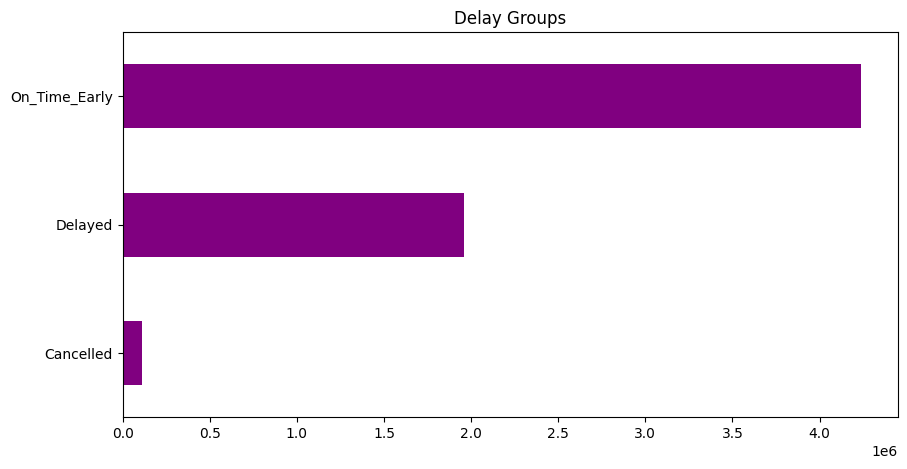

In [22]:
# Delay time grouping
df_flights["DelayGroup"].value_counts(ascending=True).plot(
    kind="barh", figsize=(10, 5), color='purple', title="Delay Groups"
)
plt.show()

In [30]:
y = df_flights["DelayGroup"]
features =  [
    # "FlightDate",
    "Airline",
    "Tail_Number",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    "DestAirportID",
    "DestCityName",
    "DestStateName"
]
X = df_flights[features]


# Handle categorical features with frequency encoding so that they can be undersampled using Near Miss:

le = LabelEncoder()
for col in cat_col:
    X.loc[:, col] = le.fit_transform(X[col])  # Use .loc for explicit assignment



# Apply frequency encoding:
for col in cat_col:
    X = frequency_encode(col, X)
    X.drop(col, axis=1, inplace=True)  # Remove original categorical column


# undersample to a specific proportion of the minority class size:
minority_class_size = min(Counter(y).values())
undersampling_ratio = 5 # Set this to the desired ratio (e.g., 2x of minority class)
n_samples = minority_class_size * undersampling_ratio
# Use NearMiss for efficient nearest neighbor-based undersampling
nearmiss = NearMiss(sampling_strategy={'On_Time_Early': n_samples,'Delayed': n_samples})
X_resampled, y_resampled = nearmiss.fit_resample(X, y)
train_X, X_test, train_y, y_test = train_test_split(X_resampled, y_resampled, random_state=2024)


# Compute class weights for balanced training
classes = np.unique(y_resampled)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)
class_weights = dict(zip(classes, weights))

# Train CatBoost model with undersampled data and class weights
model = cb.CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights=class_weights,
                                iterations=500, learning_rate=0.01,
                                thread_count=None, random_state=2024)


# Create and train the RUSBoost model
# rus_model = RUSBoostClassifier(base_estimator=model,
#                                n_estimators=100, random_state=2024)
# rus_model.fit(train_X, train_y)

model.fit(train_X, train_y,
             eval_set=(X_test, y_test),
             early_stopping_rounds=5,
            #  cat_features=cat_col,
             use_best_model=True)
y_pred_test = model.predict(X_test)
score = accuracy_score(y_test, y_pred_test)
print(score)

y_pred_proba = model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)
print(f"Multiclass Log Loss: {logloss:.4f}")

C:\Users\LAIW0\AppData\Local\Temp\ipykernel_13292\2392606668.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, col] = le.fit_transform(X[col])  # Use .loc for explicit assignment
C:\Users\LAIW0\AppData\Local\Temp\ipykernel_13292\2392606668.py:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, col] = le.fit_transform(X[col])  # Use .loc for explicit assignment
C:\Users\LAIW0\AppData\Local\Temp\ipykernel_13292\2392606668.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

0:	learn: 0.6907940	test: 0.6908076	best: 0.6908076 (0)	total: 173ms	remaining: 1m 26s
1:	learn: 0.6884360	test: 0.6884655	best: 0.6884655 (1)	total: 337ms	remaining: 1m 23s
2:	learn: 0.6861323	test: 0.6861748	best: 0.6861748 (2)	total: 501ms	remaining: 1m 23s
3:	learn: 0.6838785	test: 0.6839335	best: 0.6839335 (3)	total: 666ms	remaining: 1m 22s
4:	learn: 0.6816878	test: 0.6817538	best: 0.6817538 (4)	total: 832ms	remaining: 1m 22s
5:	learn: 0.6795215	test: 0.6796001	best: 0.6796001 (5)	total: 996ms	remaining: 1m 22s
6:	learn: 0.6773997	test: 0.6774910	best: 0.6774910 (6)	total: 1.18s	remaining: 1m 23s
7:	learn: 0.6752742	test: 0.6753749	best: 0.6753749 (7)	total: 1.35s	remaining: 1m 23s
8:	learn: 0.6732480	test: 0.6733619	best: 0.6733619 (8)	total: 1.52s	remaining: 1m 23s
9:	learn: 0.6712374	test: 0.6713613	best: 0.6713613 (9)	total: 1.69s	remaining: 1m 23s
10:	learn: 0.6692272	test: 0.6693590	best: 0.6693590 (10)	total: 1.9s	remaining: 1m 24s
11:	learn: 0.6672915	test: 0.6674334	best:

C:\Users\LAIW0\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6307336 entries, 0 to 6307335
Data columns (total 11 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Flight_Number_Marketing_Airline  int64  
 1   OriginAirportID                  int64  
 2   DestAirportID                    int64  
 3   Airline_freq                     float64
 4   Origin_freq                      float64
 5   Dest_freq                        float64
 6   OriginStateName_freq             float64
 7   DestStateName_freq               float64
 8   Tail_Number_freq                 float64
 9   OriginCityName_freq              float64
 10  DestCityName_freq                float64
dtypes: float64(8), int64(3)
memory usage: 529.3 MB


Confusion Matrix with Labels:
                Cancelled  Delayed  On_Time_Early
Cancelled          13400     2928          11260
Delayed            16902    47119          74508
On_Time_Early      12485    16009         110689

Precision:
 0.5299747773282256

Recall:
 0.5403777721104682


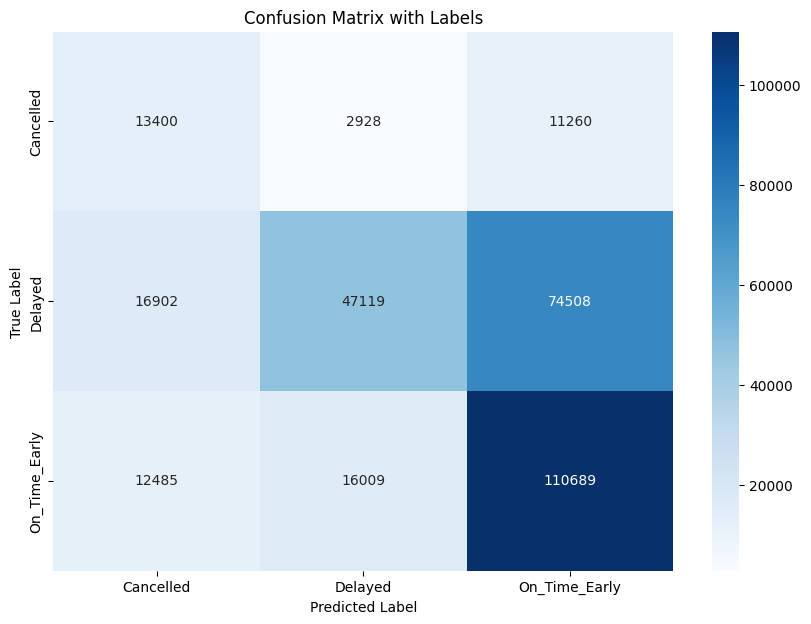

In [31]:
# Get predicted labels
y_pred = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract class labels from the target variable
class_labels = np.unique(y_test)

# Label the confusion matrix
cm_labeled = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Print the labeled confusion matrix
print("Confusion Matrix with Labels:\n", cm_labeled)

# Calculate precision, recall, and F1-score (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')


print("\nPrecision:\n", precision)
print("\nRecall:\n", recall)


# Visualize the confusion matrix (optional)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm_labeled, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with Labels")
plt.show()

In [19]:
y2 = df_flights['ArrDelayMinutes']
y2.value_counts()

NameError: name 'df_flights' is not defined

In [27]:
y_resampled.value_counts()
print("Class distribution after undersampling:")
print(Counter(y_resampled))

Class distribution after undersampling:
Counter({'Delayed': 333054, 'On_Time_Early': 333054, 'Cancelled': 111018})


In [28]:
y_pred_test

array([['On_Time_Early'],
       ['On_Time_Early'],
       ['Delayed'],
       ...,
       ['On_Time_Early'],
       ['On_Time_Early'],
       ['On_Time_Early']], dtype=object)

In [29]:
df_flights['Airline'].value_counts()

Southwest Airlines Co.                       1063867
SkyWest Airlines Inc.                         752805
Delta Air Lines Inc.                          747414
American Airlines Inc.                        735766
United Air Lines Inc.                         446724
Republic Airlines                             332735
Endeavor Air Inc.                             266815
Envoy Air                                     255610
Comair Inc.                                   222448
JetBlue Airways                               202436
Spirit Air Lines                              191161
Alaska Airlines Inc.                          188643
Mesa Airlines Inc.                            159719
Frontier Airlines Inc.                        136976
Allegiant Air                                 115762
Horizon Air                                   111481
Capital Cargo International                    99284
Air Wisconsin Airlines Corp                    80252
Commutair Aka Champlain Enterprises, Inc.     